In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Janome

     |████████████████████████████████| 19.7 MB 6.4 MB/s 


In [ ]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu as bleu
from janome.tokenizer import Tokenizer as janome_tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import warnings
import time
import re
import os
# warnings.filterwarnings("ignore", message="Glyph \d+ missing from current font.")
warnings.simplefilter("ignore")
sns.set()
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()

In [ ]:
file = open('/content/drive/MyDrive/jpn.txt').read()

In [ ]:
X = file.split('\n')
X.pop()

''

In [ ]:
arr = []
arr = [line.split('\t')[:2] for line in X]

In [ ]:
data = pd.DataFrame(arr, columns=['English', 'Japanese'])

In [ ]:
data.head(10)

,English,Japanese
0,Go.,行け。
1,Go.,行きなさい。
2,Hi.,こんにちは。
3,Hi.,もしもし。
4,Hi.,やっほー。
5,Hi.,こんにちは！
6,Run.,走れ。
7,Run.,走って！
8,Who?,誰？
9,Wow!,すごい！


In [ ]:
data.shape

(53594, 2)

In [ ]:
data.tail(10)

,English,Japanese
53584,The National Center for Education Information ...,全国教育情報センターによれば、退職した教員が復職しているおかげで、予測された教員不足は起こら...
53585,The people here are particular about what they...,ここの人たちは舌が肥えていますから、安くてもまずい店はすぐにつぶれてしまうんですよ。
53586,If a person has not had a chance to acquire hi...,大人になるまでの間に身につけなかった言語について、ネイティブスピーカーのレベルに達することは...
53587,"Even at the end of the nineteenth century, sai...",１９世紀末でも、イギリス海軍の船員は、そうすることが弱さの印だという理由で、ナイフとフォーク...
53588,"Tom said, ""You can kiss your girlfriend goodby...",「恋人にさよならのキスくらいしないと、キスしてあばよ、ということになるぞ」とトムは言ったが、...
53589,Five tremors in excess of magnitude 5.0 on the...,日本ではリヒター・スケールでマグニチュード5.0以上の余震が今週5回ありました。しかし科学者...
53590,The bus now arriving is going to Domestic Term...,ただ今到着のバスは、国内線第1ターミナル行きです。国際線ターミナルにお越しの方は、しばらくそ...
53591,A child who is a native speaker usually knows ...,ネイティブの子どもは、何年も学んだ非ネイティブが知らず今後も知り得ないたくさんのことを自身の...
53592,"I do many things at the same time, so not only...",色々並行してやってるから芥川ばかり読んでるのでもないのだよ。今は英語読んでる時間が増えてる。...
53593,If someone who doesn't know your background sa...,生い立ちを知らない人にネイティブみたいに聞こえるよって言われたら、それはおそらく、あなたの喋...


In [ ]:
from janome.tokenizer import Tokenizer as janome_tokenizer
token_object = janome_tokenizer()

In [ ]:
mispell_dict = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", 
                "couldnt" : "could not", "didn't" : "did not", "doesn't" : "does not", 
                "doesnt" : "does not", "don't" : "do not", "hadn't" : "had not", 
                "hasn't" : "has not", "haven't" : "have not", "havent" : "have not", 
                "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would",
                "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", 
                "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", 
                "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", 
                "she'd" : "she would", "she'll" : "she will", "she's" : "she is", 
                "shouldn't" : "should not", "shouldnt" : "should not", "that's" : "that is", 
                "thats" : "that is", "there's" : "there is", "theres" : "there is", 
                "they'd" : "they would", "they'll" : "they will", "they're" : "they are", 
                "theyre": "they are", "they've" : "they have", "we'd" : "we would", 
                "we're" : "we are", "weren't" : "were not", "we've" : "we have", 
                "what'll" : "what will", "what're" : "what are", "what's" : "what is", 
                "what've" : "what have", "where's" : "where is", "who'd" : "who would",
                "who'll" : "who will", "who're" : "who are", "who's" : "who is", 
                "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", 
                "you'd" : "you would", "you'll" : "you will", "you're" : "you are", 
                "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", 
                "didn't": "did not", "tryin'":"trying"
                }

In [ ]:
def deconcate(sentence):
    cleaned_sentence = []
    keys = mispell_dict.keys()
    for word in sentence.split(' '):
        if word in keys:
            cleaned_sentence.append(mispell_dict[word])
        else:
            cleaned_sentence.append(word)
    return ' '.join(cleaned_sentence)

In [ ]:
def preprocess(phrase):
  phrase = phrase.strip().lower()
  phrase = deconcate(phrase)
  phrase = '<sos> '+ phrase.lower() +' <eos>'
  return phrase

In [ ]:
english, japanese = [], []\

for line in tqdm(file.split('\n')[:-1]):
  english.append(preprocess(line.split('\t')[0]))
  jp_ = ' '.join([x.surface for x in token_object.tokenize(line.split('\t')[1])])
  japanese.append(preprocess(jp_))

  0%|          | 0/53594 [00:00<?, ?it/s]

In [ ]:
print(english[1])
print(japanese[1])

<sos> go. <eos>
<sos> 行き なさい 。 <eos>


In [ ]:
_eng_len = [len(x.split(' '))-2 for x in english]
_jpn_len = [len(x.split(' '))-2 for x in japanese]

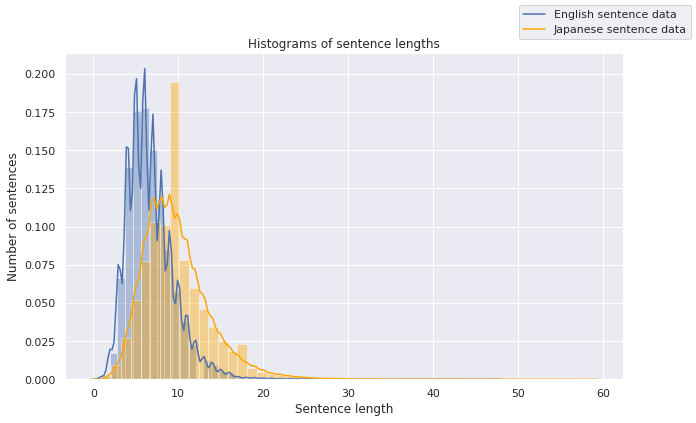

In [ ]:
sns.set()
fig = plt.figure(figsize=(10,6))
sns.distplot(_eng_len)
sns.distplot(_jpn_len, color='orange')
fig.legend(labels=['English sentence data','Japanese sentence data'])
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Histograms of sentence lengths')
plt.show()

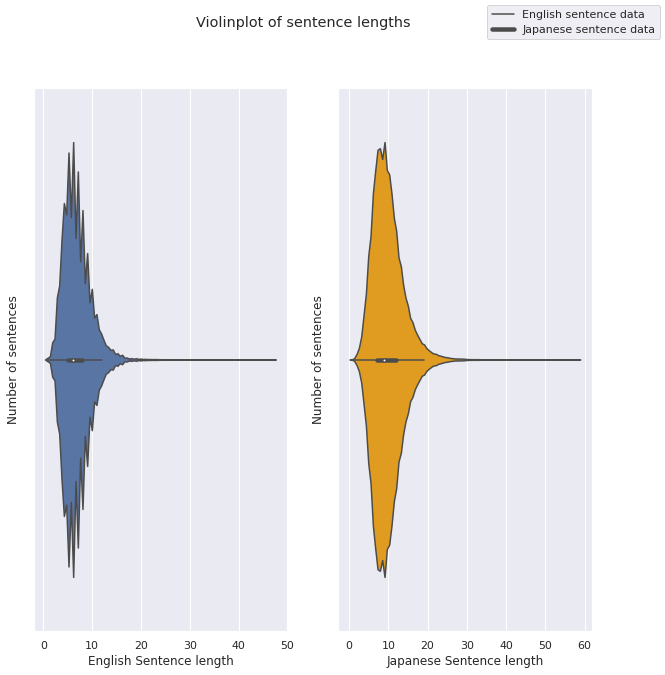

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
sns.violinplot(_eng_len, ax=ax[0], orient='v')
fig.suptitle('Violinplot of sentence lengths')
ax[0].set_xlabel('English Sentence length')
ax[0].set_ylabel('Number of sentences')
sns.violinplot(_jpn_len, ax=ax[1], orient='v', color='orange')
ax[1].set_xlabel('Japanese Sentence length')
ax[1].set_ylabel('Number of sentences')
fig.legend(labels=['English sentence data','Japanese sentence data'])
plt.show();

In [ ]:
# initializing tokenizer To convert the words into numerical representation
filters = "+1234567890\"#$%&()*+,-/:;=@[\\]^_`{|}~'"
tokenizer_eng = Tokenizer(split=' ', char_level=False, filters=filters)
# fitting on english
tokenizer_eng.fit_on_texts(english)
eng_tokens = tokenizer_eng.texts_to_sequences(english)
# fitting on japanese
tokenizer_jpn = Tokenizer(lower=True, split=' ', char_level=False, filters=filters)
tokenizer_jpn.fit_on_texts(japanese)
jpn_tokens = tokenizer_jpn.texts_to_sequences(japanese)

In [ ]:
# defining the vocabulary size of english and japanese language in the given data.
eng_vocab = len(tokenizer_eng.word_index.items()) + 1
jpn_vocab = len(tokenizer_jpn.word_index.items()) + 1

In [ ]:
# defining the max length of english and japanese sentence in the given data (for padding).
eng_max = max([len(e) for e in eng_tokens])
jpn_max = max([len(i) for i in jpn_tokens])

In [ ]:
# Padding the tokenized data
eng_padded = pad_sequences(eng_tokens, maxlen=eng_max, padding='post')
jpn_padded = pad_sequences(jpn_tokens, maxlen=jpn_max, padding='post')

In [ ]:
# splitting data into train and test
eng_tr, eng_te, jpn_tr, jpn_te = train_test_split(eng_padded, jpn_padded, test_size=0.03, random_state=42)

In [ ]:
eng_tr.shape, jpn_tr.shape, eng_te.shape, jpn_te.shape

((51986, 49), (51986, 60), (1608, 49), (1608, 60))

In [ ]:
eng_tr[1]

array([   1,   85, 2783,    7,  827,    2,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
jpn_tr[1]

array([  1, 748, 160,  46,  44, 214,   6,   8, 114,   9,  95,   9,   3,
         2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Defining the Encoder and Decoder models

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, name="embedding_layer_encoder")
        self.lstm = CuDNNLSTM(self.enc_units, return_state=True, return_sequences=True,
                             recurrent_initializer='glorot_uniform', name="Encoder_LSTM")
        
    def call(self, input_sentances, state_h, state_c, training=True):
        input_embedd = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h, self.state_c = self.lstm(input_embedd, initial_state=[state_h, state_c])
        return self.lstm_output, self.lstm_state_h

    def initialize_hidden_state(self, batch_sz):
        return [tf.zeros((batch_sz, self.enc_units)), tf.zeros((batch_sz, self.enc_units))]

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.dense = tf.keras.layers.Dense(vocab_size)
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, name="embedding_layer_decoder")
        self.lstm = CuDNNLSTM(self.dec_units, return_state=True, return_sequences=True,
                             recurrent_initializer='glorot_uniform', name="Encoder_LSTM")
        
    def call(self, target_sentances, enc_output, state_h):
        target_embedd = self.embedding(target_sentances)
        # concat method as content-based function
        hidden_with_time_axis = tf.expand_dims(state_h, 1) # expanding layer dimension for compatibility with encoder_output tensor
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))) # calculating score
        attention_weights = tf.nn.softmax(score, axis=1) # calculating attention_weights
        context_vector = attention_weights * enc_output # calculating context_vector
        context_vector = tf.reduce_sum(context_vector, axis=1) # preparing context vector to make it compatible with target_embedd
        target_embedd = tf.concat([tf.expand_dims(context_vector, 1), target_embedd], axis=-1) # concatenating context vector and target_embeddings
        lstm_output, state_h, state_c = self.lstm(target_embedd) # getting result from lstm
        lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2])) # Making the output compatible for dense layer for (vocab representation)
        dec_output = self.dense(lstm_output) # getting vocab size output
        return  attention_weights, dec_output, state_h, attention_weights

    def initialize_hidden_state(self, batch_sz):
        return [tf.zeros((batch_sz, self.enc_units)), tf.zeros((batch_sz, self.enc_units))]

### Define Loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
def loss_function(real, pred):
    mask = tf.cast(tf.cast(real, dtype=tf.bool), dtype=tf.float32) #mask to elemenate the loss due <pad> values
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

### BLEU score function

In [ ]:
warnings.simplefilter("ignore")
# I'll be calculating the BLEU score in 1000 random datapoints from test data.
def bleu_score_calc(encoder, decoder):
    size = 1000
    pts = np.random.randint(0, jpn_te.shape[0], size)
    q = jpn_te[pts]
    questions = [t.split(' ')[1:-1] for t in tokenizer_jpn.sequences_to_texts(q)]

    a = eng_te[pts]
    answers = [t.split(' ')[1:-1] for t in tokenizer_eng.sequences_to_texts(a)]

    inputs = tf.convert_to_tensor(q)
    
    state_h, state_c = [tf.zeros((size, units)), tf.zeros((size, units))]
    encoder_output, state_h = encoder(inputs, state_h, state_c)
    decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0]*size, 1)
    
    result = []
    for i in range(eng_max):
        attention_wts, decoder_output, state_h, _ = decoder(decoder_input, encoder_output, state_h)
        predicted_word = tf.argmax(decoder_output, axis=1).numpy()
        result.append(tokenizer_eng.sequences_to_texts(predicted_word.reshape(-1,1)))
        decoder_input = tf.expand_dims(predicted_word, 1)
    result = np.array(result).T
    guesses = [x[:np.where(x=='<eos>')[0][0]] if ('<eos>' in x) else x for x in result]

    return np.mean([bleu([x],y) for x,y in zip(answers, guesses)])

### Function for plotting the heatmap of Annotation weights

In [ ]:

def plot_heatmap(df):
    plt.figure(figsize=(16,10))
    plt.title('heatmap of Annotation weights')
    heatmap = plt.pcolor(df)

    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
          plt.text(x + 0.5, y + 0.5, '%.3f' % df.values[y, x],
                  horizontalalignment='center',
                  verticalalignment='center')

    plt.colorbar(heatmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.show()

In [ ]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

### Gradient calculation and update

In [ ]:
@tf.function
def train_step(encoder, decoder, state_h, state_c, inputs, target):
    loss = 0
    with tf.GradientTape() as tape:
        encoder_output, state_h = encoder(inputs, state_h, state_c)
        decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0] * BATCH_SIZE, 1)
        
        for t in range(1, target.shape[1]):
            attention_wts, decoder_output, state_h, score = decoder(decoder_input, encoder_output, state_h)
            loss += loss_function(target[:, t], decoder_output)
            decoder_input = tf.expand_dims(target[:, t], 1)
        
        
    batch_loss = (loss/int(target.shape[1]))
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(batch_loss)
    v_name = []
    for v in variables:
        v_name.append(v.name)
        
    return batch_loss, v_name, gradients

### Creating Attention Model

In [ ]:
class MyModel(Model):
    def __init__(self, jpn_vocab, eng_vocab, embedding_dim, units):
        super().__init__()
        self.encoder = Encoder(jpn_vocab, embedding_dim, units)
        self.decoder = Decoder(eng_vocab, embedding_dim, units)
        self.optimizer = tf.keras.optimizers.Adam()
        self.state_h = 0
        self.state_c = 0
        self.batch_loss = 0
        
    def fit(self, dataset, BATCH_SIZE, epochs):
        tf.summary.trace_on(graph=True, profiler=False)
        for epoch in range(epochs):
            start = time.time()
            total_loss = 0
            self.state_h, self.state_c = self.encoder.initialize_hidden_state(BATCH_SIZE)
            
            for (batch, (inputs, target)) in enumerate(dataset):
                batch_loss, variables, gradients = train_step(self.encoder, self.decoder, self.state_h, self.state_c, inputs, target)
                total_loss += batch_loss
                if batch % 100 == 0:
                    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            bleu_score = bleu_score_calc(self.encoder, self.decoder)
            print('Epoch {} Loss {:.4f} BLEU-score {}'.format(epoch+1, total_loss/N_BATCH, bleu_score))
            print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
            
            tf.summary.trace_off()
            print('training completed...!')
            print('returning gradients...')
            train_loss.reset_states()
            
            
            # function for translating the input japanese sentence to english and plotting the annotation/attention scores.
            # If no sentence is passed, it picks a random sentence from Japanese test data
            
    def test(self, input_sentence=''):
        if(input_sentence==''):
            k = np.random.randint(len(jpn_te))
            w = jpn_tr[k] # a random sentence sequence from the input language
            asked = tokenizer_jpn.sequences_to_texts([w])[0] # converting the input sequence into text
            print(f"input sentence: {' '.join(asked.split(' ')[1:-1])}") # printing the input text sequence
            o = eng_tr[k] # a random sentence sequence from the output language
            o = tokenizer_eng.sequences_to_texts([o])[0] # converting the output sequence into text
            print(f"actual translation: {' '.join(o.split(' ')[1:-1])}") # printing the output text sequence
            
        else: 
            inp = ' '.join([x.surface for x in token_object.tokenize(input_sentence)])
            prep = preprocess(inp)
            jp_tkn = tokenizer_jpn.texts_to_sequences([prep])
            w = pad_sequences(jp_tkn, maxlen=jpn_max, padding='post')[0]
            asked = tokenizer_jpn.sequences_to_texts([w])[0] # converting the input sequence into text
            print(f"input sentence: {' '.join(asked.split(' ')[1:-1])}") # printing the input text sequence
            
            
        # preparing input for attention model
        inputs = tf.convert_to_tensor(w.reshape(1,-1)) # initializing the input as a tensor
        state_h, state_c = [tf.zeros((1, units)), tf.zeros((1, units))] # initializing the hidden layers (all zeros)
        encoder_output, state_h = self.encoder(inputs, state_h, state_c)
        decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0], 0) # decoder initial input as all <sos>
        # translating sentence
        attention = []
        result = ''
        
        for i in range(eng_max):
            attention_wts, decoder_output, state_h, _ = self.decoder(decoder_input, encoder_output, state_h)
            attention_wts = attention_wts.numpy().flatten()
            predicted_word = tf.argmax(decoder_output[0]).numpy()
            if predicted_word == tokenizer_jpn.texts_to_sequences(['<eos>'])[0][0]:
                break
            result += tokenizer_eng.sequences_to_texts([[predicted_word]])[0] + ' '
            decoder_input = tf.expand_dims([predicted_word], 0)
            attention.append(attention_wts[1:len(asked.split(' '))-1])
        
        print(f'predicted translation: {result}')
        
        
        attention = np.array(attention)
        index = result.split(' ')[:-1]
        columns = asked.split(' ')[1:-1]
        
        atten = pd.DataFrame(attention, columns=columns, index=index)
        plot_heatmap(atten)

### Defining some more parameters and training the model

In [ ]:
BUFFER_SIZE = len(eng_tr)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 128
units = 256
EPOCHS = 10
print(N_BATCH)

dataset = tf.data.Dataset.from_tensor_slices((jpn_tr, eng_tr)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

812


In [ ]:
tf.keras.backend.clear_session()
model = MyModel(jpn_vocab, eng_vocab, embedding_dim, units)
model.fit(dataset, BATCH_SIZE, EPOCHS)
model.save_weights('jpn_to_eng.h5')

Epoch 1 Batch 0 Loss 1.6222
Epoch 1 Batch 100 Loss 1.0067
Epoch 1 Batch 200 Loss 0.9225
Epoch 1 Batch 300 Loss 0.8624
Epoch 1 Batch 400 Loss 0.9040
Epoch 1 Batch 500 Loss 0.8615
Epoch 1 Batch 600 Loss 0.7622
Epoch 1 Batch 700 Loss 0.7746
Epoch 1 Batch 800 Loss 0.7949
Epoch 1 Loss 0.8918 BLEU-score 0.17430132179833582
Time taken for 1 epoch 373.0455868244171 sec

training completed...!
returning gradients...
Epoch 2 Batch 0 Loss 0.7615
Epoch 2 Batch 100 Loss 0.7062
Epoch 2 Batch 200 Loss 0.7513
Epoch 2 Batch 300 Loss 0.7123
Epoch 2 Batch 400 Loss 0.7593
Epoch 2 Batch 500 Loss 0.7335
Epoch 2 Batch 600 Loss 0.7561
Epoch 2 Batch 700 Loss 0.5932
Epoch 2 Batch 800 Loss 0.5896
Epoch 2 Loss 0.7239 BLEU-score 0.38897933533057083
Time taken for 1 epoch 320.8242311477661 sec

training completed...!
returning gradients...
Epoch 3 Batch 0 Loss 0.6643
Epoch 3 Batch 100 Loss 0.6608
Epoch 3 Batch 200 Loss 0.6225
Epoch 3 Batch 300 Loss 0.6612
Epoch 3 Batch 400 Loss 0.5479
Epoch 3 Batch 500 Loss 0.6304


input sentence: 彼 は 私 たち の 助力 を 求め て やって来 た 。
actual translation: he came to ask us for our help.
predicted translation: he came to me. 


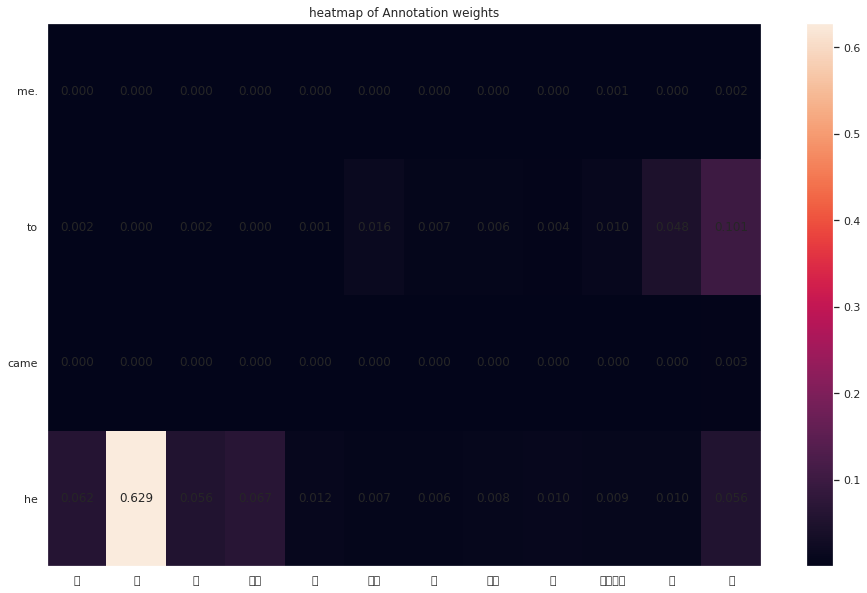

In [ ]:
model.test()

input sentence: この 部屋 用 に 新しい じゅうたん を 買わ なけれ ば いけ ない 。
actual translation: we must buy a new carpet for this room.
predicted translation: i have to buy a new carpet for this room. 


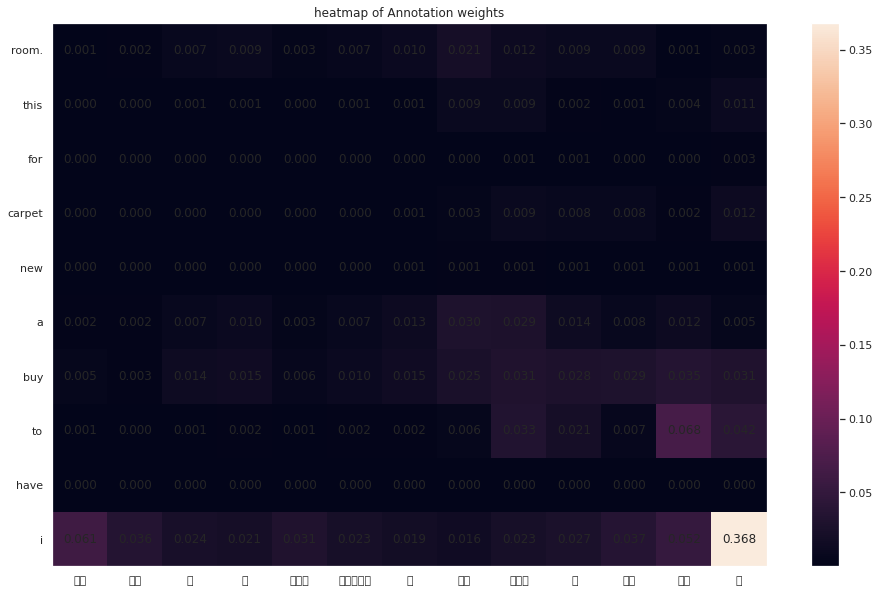

In [ ]:
model.test()

input sentence: 入院 中 の 祖母 の お 見舞い に 行く ん です 。
actual translation: i am visiting my grandmother in the hospital.
predicted translation: i am taking a car. 


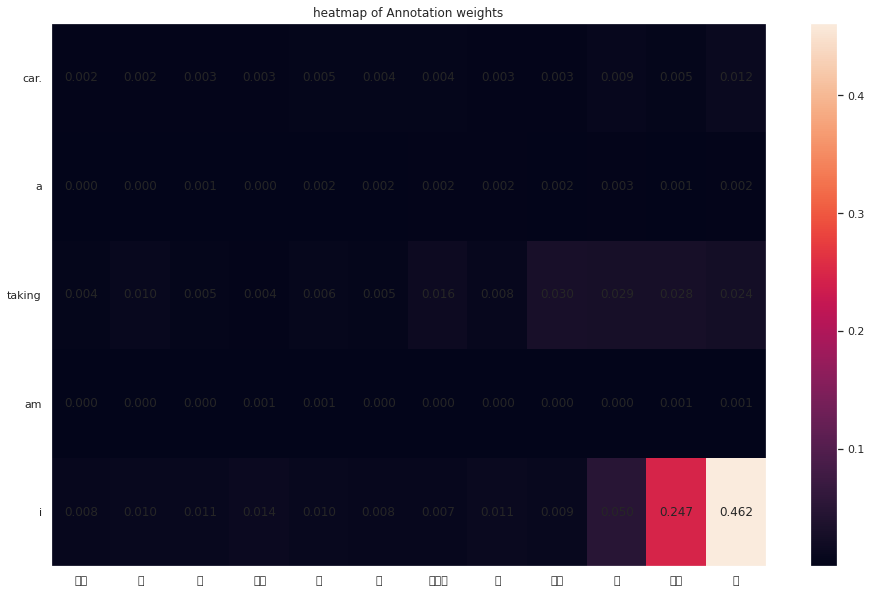

In [ ]:
model.test()

input sentence: 彼 は 医者 です
predicted translation: he is a doctor. 


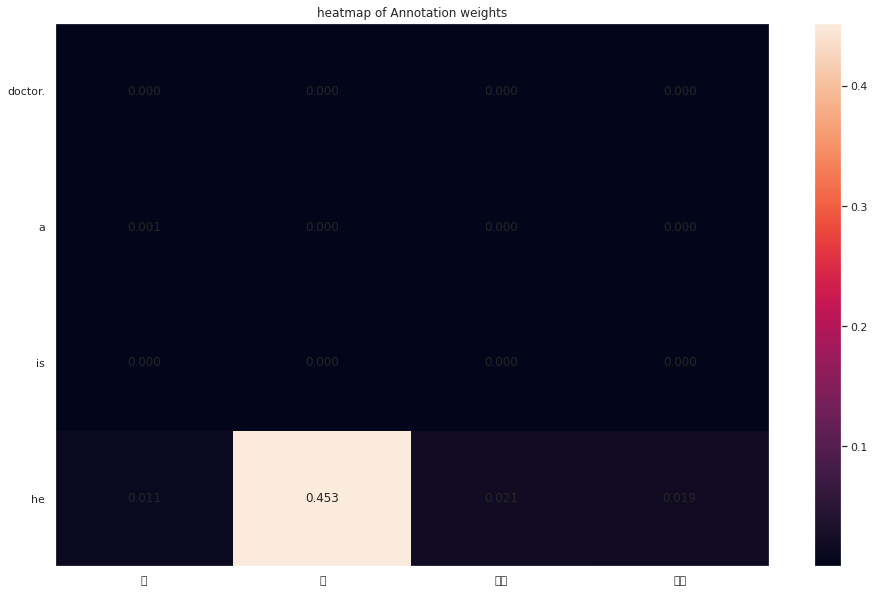

In [ ]:
model.test('彼は医者です')

input sentence: 私 たち は 行く の ？
predicted translation: are you going to go? 


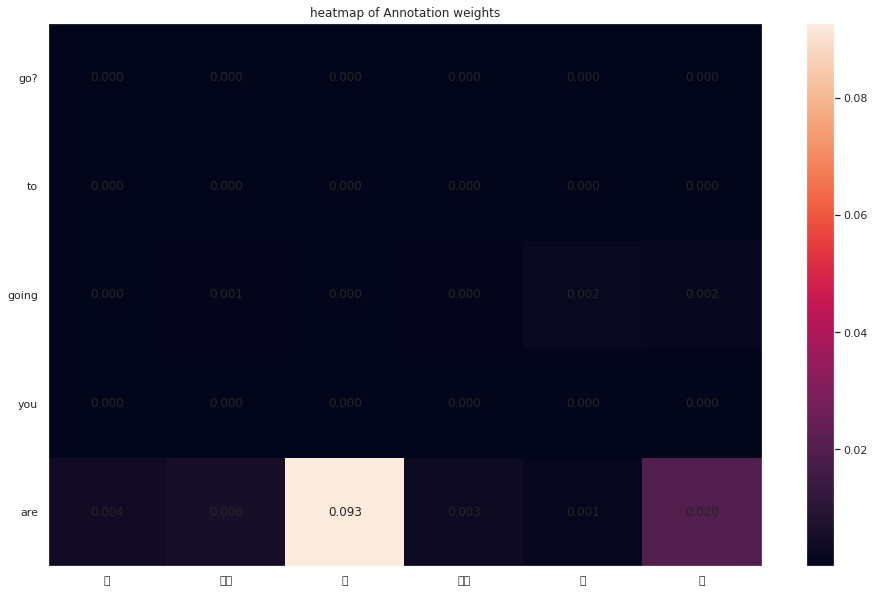

In [ ]:
model.test('私たちは行くの？')

input sentence: 私 は 忙しい 夕食 です
predicted translation: i am busy now. 


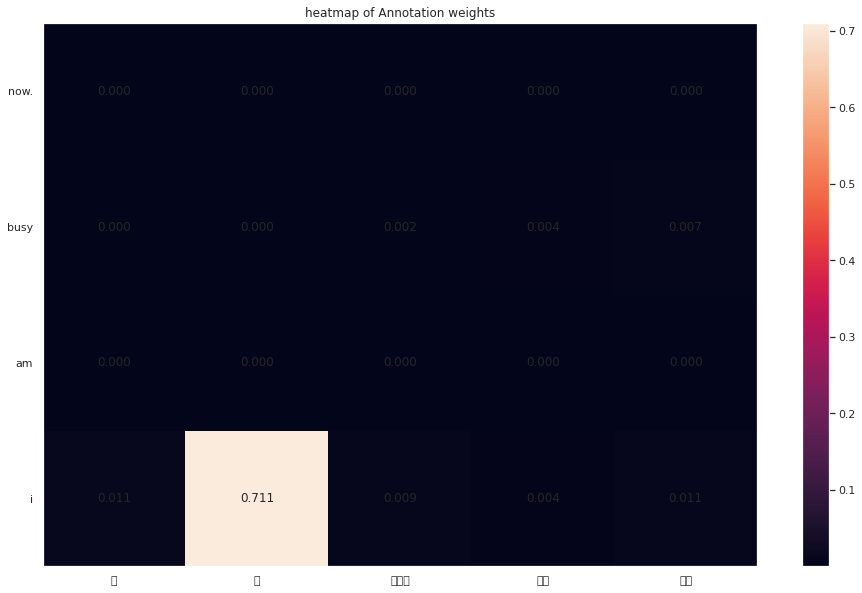

In [ ]:
model.test('私は忙しい夕食です')

input sentence: トム は ラジオ を 聞い て い ます
predicted translation: tom is sitting on the window. 


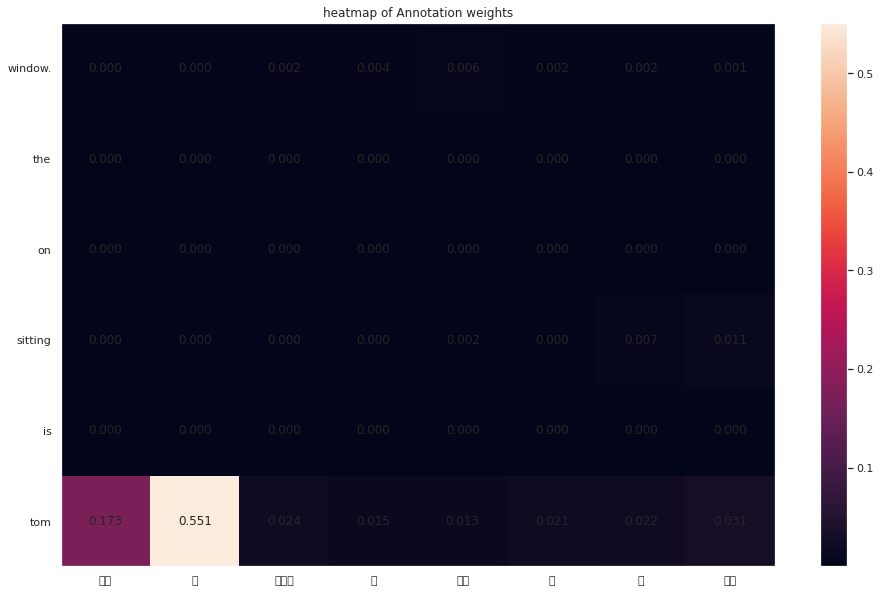

In [ ]:
model.test('トムはラジオを聞いています')

input sentence: 私 は あなた に 助言 出来る 立場 に い ない 。
actual translation: i am not in a position to give you any advice.
predicted translation: i am not going to you. 


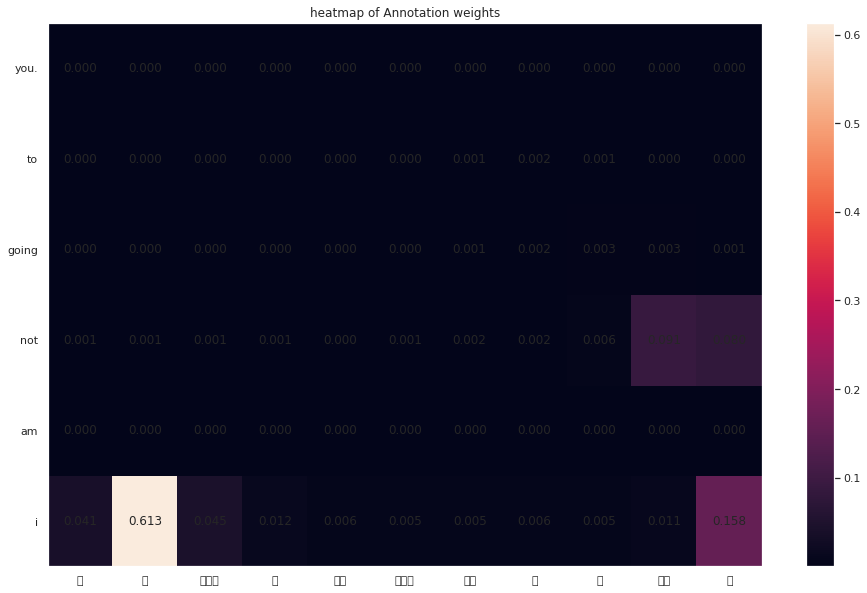

In [ ]:
model.test()

input sentence: トム は ラジオ を 聞い て い ます
predicted translation: tom is sitting on the window. 


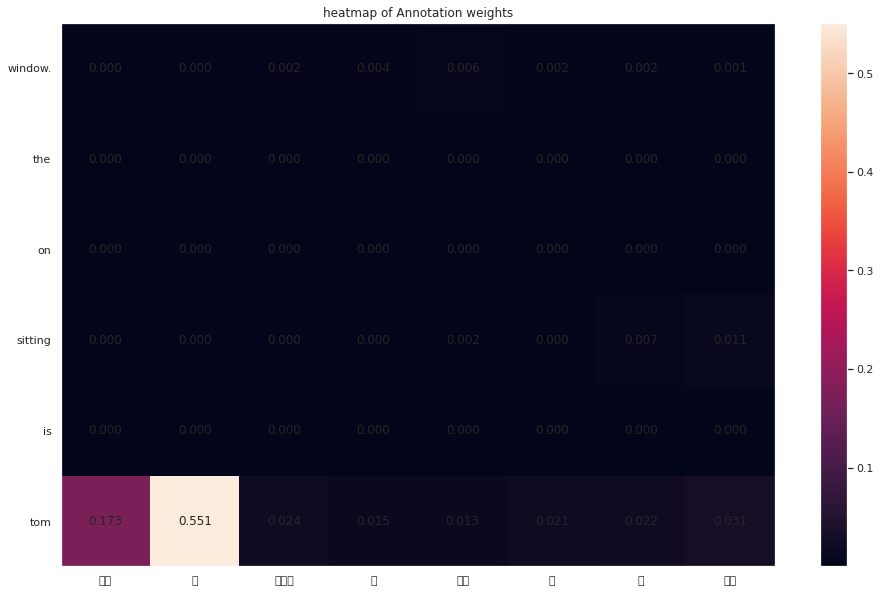

In [ ]:
model.test('トムはラジオを聞いています')

input sentence: 僕ら は 読め た 。
actual translation: we could read.
predicted translation: we could ve kept up. 


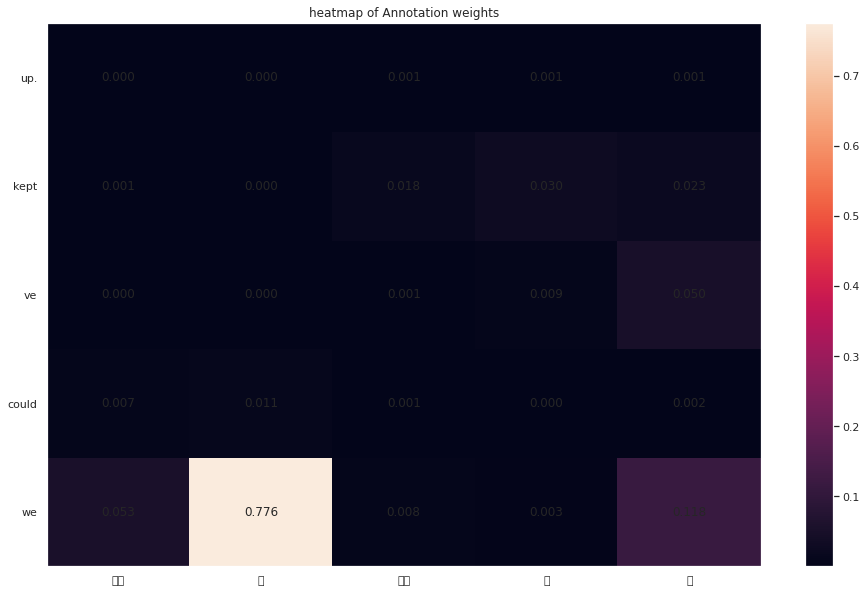

In [ ]:
model.test()